# Import

In [69]:
import pandas as pd
import json
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models
import re
import math
from scipy.stats import normaltest, f_oneway, kruskal
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy.sparse as scp
import itertools

In [70]:
!pip install biopython

In [71]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

# Formulae

## HW

In [72]:
def HW(list1, list2):
  counter_1 = Counter(list1)
  counter_2 = Counter(list2)
  final_counter_1, final_counter_2 = common_grams_counter(list1, list2)
  overall = len(counter_1) + len(counter_2)
  AA = 0
  Aa = 0
  for i in range(len(final_counter_1)):
    if (final_counter_1.most_common()[i][0] == final_counter_2.most_common()[i][0]):
      AA = AA + 2
      continue
    Aa = Aa + 2
  aa = (len(counter_1) - len(final_counter_1)) + (len(counter_2) - len(final_counter_2))
  A = AA/overall + 0.5*(Aa/overall)
  a = aa/overall + 0.5*(Aa/overall)
  p_squared = math.pow(A, 2)
  doubled_product_p_q = 2*A*a
  q_squared = math.pow(a, 2)
  return {'AA': AA, 'Aa' : Aa, 'aa': aa, 'A': A, 'a': a, 'p_squared': p_squared, '2pq' : doubled_product_p_q, 'q_squared': q_squared}


## Metrics

### Damerau-Levenshtein distance

In [73]:
def dameraulevenshtein(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i]==s2[j-1] and s1[i-1] == s2[j]:
                d[(i,j)] = min (d[(i,j)], d[i-2,j-2] + cost) # transposition
    return d[lenstr1-1,lenstr2-1] 

In [74]:
def full_levenshtein(l1, l2):
  return dameraulevenshtein(''.join(l1), ''.join(l2))

### DistRank - UniqueCounter - F1



In [75]:
def dist_ranks(counter_1, counter_2):
  ranks = []
  count_1 = 0
  count_2 = 0
  for i in counter_1.items():
    count_1 = count_1 + 1
    for j in counter_2.items():
      count_2 = count_2 + 1
      if (i[0] == j[0]):
        ranks.append(abs(count_1 - count_2))
        count_2 = 0
        break
  return ranks

In [76]:
def top_dist_rank(counter_1, counter_2, percentile = 95):
    res_dist_rank = dist_ranks(counter_1, counter_2)
    rim = np.percentile(res_dist_rank, [percentile])
    result_list = []
    count_1 = 0
    count_2 = 0
    for i in counter_1.items():
      count_1 = count_1 + 1
      for j in counter_2.items():
        count_2 = count_2 + 1
        if (i[0] == j[0]):
          rank = abs(count_1 - count_2)
          if (rank > rim):
            result_list.append((i[0], rank))
          count_2 = 0
          break
    return result_list

In [77]:
def normalized_dist_rank(counter_1, counter_2):
  ranks = dist_ranks(counter_1, counter_2)
  sum_ranks = sum(ranks)
  max_rank = 2 * sum([i for i in range(1, len(counter_1) + 1, 2)])
  if (sum_ranks/max_rank > 1):
    print(ranks)
  return sum_ranks/max_rank

In [78]:
def plot_dist_rank(counter_1, counter_2):
  ranks = []
  count_1 = 0
  count_2 = 0
  ranks_counter_1 = []
  ranks_counter_2 = []
  for i in counter_1.items():
    count_1 = count_1 + 1
    for j in counter_2.items():
      count_2 = count_2 + 1
      if (i[0] == j[0]):
        ranks.append(abs(count_1 - count_2))
        ranks_counter_1.append(count_1)
        ranks_counter_2.append(count_2)
        count_2 = 0
        break
  return [range(len(ranks)), ranks]

In [79]:
def common_grams_counter(list1, list2):
  final_list_1 = []
  final_list_2 = []
  for item in list1:
    for item1 in list2:
      if (item1 == item):
        final_list_2.append(item1)
  for item in list2:
    for item1 in list1:
      if (item1 == item):
        final_list_1.append(item1)
  return Counter(final_list_1), Counter(final_list_2)

In [80]:
def diff_grams_counter(list1, list2):
  counter_1 = Counter(list1)
  counter_2 = Counter(list2)
  final_counter_1, final_counter_2 = common_grams_counter(list1, list2)
  return ((len(counter_1) - len(final_counter_1))/len(counter_1) + (len(counter_2) - len(final_counter_2))/len(counter_2))/2  

In [81]:
def F1(precision, recall):
  return 2 * ((precision * recall)/(precision + recall))

### F-statistics

In [82]:
def FST(list1, list2):
  _HW = HW(list1, list2)
  equilibrium = _HW["2pq"]
  F = (equilibrium - _HW["Aa"]/(len(list1) + len(list2)))/equilibrium
  return F

### Shifts

#### Damerau-Levenshtein distance shifts

In [83]:
def norm_levenshteins(list_levs):
  return list(map(lambda x: x/max(list_levs), list_levs))

In [84]:
def shift(list_levs):
  bin_sum = sum(norm_levenshteins(list_levs))
  bin_length = len(norm_levenshteins(list_levs))
  bin_maximum = max(norm_levenshteins(list_levs))
  return (math.log(bin_sum/bin_length + 1)/math.log(bin_maximum + 1))

In [85]:
def previous_change(list_levs):
  return shift(list_levs) - 1/(len(list_levs))

#### F1 shift

In [86]:
def shift_F1(F1, common_length):
  return F1 - 1/common_length

## Topic Modelling

In [87]:
def vectorize_cols(cols):
  vectorizer = TfidfVectorizer()
  sparse_matrix = vectorizer.fit_transform(cols)
  return sparse_matrix

In [88]:
def get_stopwordness(word, docs):
  number = 0
  exists_in = 0
  for doc in docs:
    found = False
    for term in doc:
      if (term == word):
        found = True
        number = number + 1
    if (found):
      exists_in = exists_in + 1
  return number * exists_in 

In [89]:
def get_stop_words(vocabulary, docs, slope = -1):
  all_stopwordnesses = [get_stopwordness(word, docs) for word in vocabulary]
  all_stopwordnesses_normalized = [((stopwordness * len(all_stopwordnesses))/max(all_stopwordnesses)) for stopwordness in all_stopwordnesses]
  decreasing_stopwordness = list(reversed(sorted(all_stopwordnesses))) 
  normalized_decreasing_stopwordness = list(sorted(all_stopwordnesses)) 
  cutpoint_index = 0
  continuation = True
  while (continuation):
    b = normalized_decreasing_stopwordness[cutpoint_index] - slope * cutpoint_index
    j = cutpoint_index + 1
    while ((j < len(all_stopwordnesses)) and (normalized_decreasing_stopwordness[j] > (slope * j + b))):
      j = j + 1
    if (j <= len(all_stopwordnesses) - 1):
      cutpoint_index = j
    else:
      continuation = False
  stopwords = []
  for word in vocabulary:
    if (get_stopwordness(word, docs) >= decreasing_stopwordness[cutpoint_index]):
      stopwords.append(word)
  return set(stopwords)

In [90]:
def dirichlet(texts):
  dictionary_LDA = corpora.Dictionary(texts)
  dictionary_LDA.filter_extremes(no_below=2)
  corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in texts]

  num_topics = 5
  %time
  lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                    id2word=dictionary_LDA, \
                                    passes=4, alpha=[0.01]*num_topics, \
                                    eta=[0.01]*len(dictionary_LDA.keys()))
  return lda_model


# JSON loading

In [91]:
!unzip -O utf-8 /content/documents.zip -d documents

Archive:  /content/documents.zip
  inflating: documents/0_Договор неизвестного смоленского князя и Ригой и Готским берегом.json  
  inflating: documents/1_Грамота кн. Герденя  о его договоре с лив. магистром [Конрадом фон Мандерном]  и городами Ригой, Полоцком и Витебском.json  
  inflating: documents/2_Грамота («слово») кн. пол. Изяслава  [архиеп.] риж., лив. магистру, совету  и «всем горожанам» г. Риги о заключении договора.json  
  inflating: documents/3_Послание полоцкого епископа Якова в Ригу.json  
  inflating: documents/4_Договор великого князя Александра Невского и новгородцев с немецкими послами о взаимных торговых сношениях.json  
  inflating: documents/5_Мирный договор князя Ярослава Владимировича и новгородцев с немецкими послами.json  
  inflating: documents/6_Грамота князя Фёдора Ростиславича  по судному делу о немецком колоколе.json  


In [92]:
def load_json_dataset(datafile):
    with open(datafile, encoding='utf-8') as f:
        d = json.load(f)
    dataset = pd.DataFrame(columns=['ID', 'DOC', 'TOKEN', 'CONCEPT', 'LOCATION', 'CATEGORY'])
    counter = 0
    for t in d["texts"]:
        for c in t["clauses"]:
            for r in c["realizations"]:
              if r["realizationFields"]:
                categories = []
                found = False 
                for tagging in r["realizationFields"]:
                    if "Category" in tagging:
                      if not tagging["Category"][0]["name"] in categories:
                        categories.append(tagging["Category"][0]["name"])
                for tagging in r["realizationFields"]:                    
                    if "Concept" in tagging:
                      found = True
                      dataset.loc[counter] = [d["documentName"] + "_" + str(counter), d["documentName"], r["lexemeTwo"].strip(), tagging["Concept"][0]["name"].strip(), d["documentMetaData"][0]["Origin"][0]["name"], categories]
                      counter = counter + 1
                      break
                if not found and categories:
                  dataset.loc[counter] = [d["documentName"] + "_" + str(counter), d["documentName"], r["lexemeTwo"].strip(), "", d["documentMetaData"][0]["Origin"][0]["name"], categories]
                  counter = counter + 1
                  break
              else:
                dataset.loc[counter] = [d["documentName"] + "_" + str(counter), d["documentName"], r["lexemeTwo"].strip(), "", d["documentMetaData"][0]["Origin"][0]["name"], ['overall']]
                counter = counter + 1
    return dataset

In [93]:
def load_datasets(folder_path):
  list_of_files = []
  for root, dirs, files in os.walk(folder_path):
    for file in files:
      list_of_files.append(os.path.join(root, file))
  datasets = []
  for text in list_of_files:
    datasets.append(load_json_dataset(text))
  df = pd.concat(datasets)
  return df

In [94]:
df = load_datasets('/content/documents/')

# Preprocessing

In [95]:
def cleanse(df):
  df['TOKEN'] = df['TOKEN'].apply(lambda x: x.lower())
  df['TOKEN'] = df['TOKEN'].apply(lambda x: re.sub(r'\(|\)|\[|\]|', '', x))  
  #df['TOKEN'] = df['TOKEN'].apply(lambda x: 'оже' if x == 'ѡже' else x)
  return df

In [96]:
def preprocess(df):
  df = cleanse(df)
  df['TOKEN'] = df.apply(lambda row: row['TOKEN'][0:2] if row['CONCEPT'] == 'ALL' and row['TOKEN'].startswith('вс') else row['TOKEN'], axis=1)
  df['TOKEN'] = df.apply(lambda row: row['TOKEN'][0:3] if row['CONCEPT'] == 'ALL' and not row['TOKEN'].startswith('вс') else row['TOKEN'], axis=1)
  return df

In [97]:
def n_grams(word, grams):
    n_grams = []
    if ((grams == 0) or (len(word) <= grams)):
        n_grams.append(word)
    else:
        counter = 0
        while ((len(word) - counter) >= grams):
            resulting_word = ''            
            for i in range (counter, counter + grams):
                resulting_word += word[i]                
            n_grams.append(resulting_word)
            counter = counter + 1
    return n_grams

# Analysis of particular concepts

In [98]:
def split_by_concept(df_concepts, concepts, locations):
  dfs_by_concept = []
  for concept in concepts:
    df_concept_all = df_concepts[df_concepts["CONCEPT"] == concept]
    dfs_by_loc = []
    dfs_by_loc.append(df_concept_all)
    for location in locations:
      dfs_by_loc.append(df_concept_all[df_concept_all["LOCATION"] == location])
    dfs_by_concept.append(dfs_by_loc)
  return dfs_by_concept  

In [99]:
def print_by_concept(df_concepts, concepts, locations, c):
  unique_list_general = list(df_concepts[c][0]["TOKEN"].unique())
  print(concepts[c], end=': ')
  print(*unique_list_general, sep=', ')
  print('All texts: ' + str(df_concepts[c][0].shape[0]))
  for item in unique_list_general:
    print(item + '(abs): ' + str(df_concepts[c][0][df_concepts[c][0]['TOKEN'] == item].shape[0]))
    print(item + '(rel): ' + str(df_concepts[c][0][df_concepts[c][0]['TOKEN'] == item].shape[0]/df_concepts[c][0].shape[0]))
  for i in range(len(locations)):
    print(locations[i] + ": " + str(df_concepts[c][i + 1].shape[0]))
    if (df_concepts[c][i + 1].shape[0] > 0):
      for item in unique_list_general:
        print(item + '(abs): ' + str(df_concepts[c][i + 1][df_concepts[c][i + 1]['TOKEN'] == item].shape[0]))
        print(item + '(rel): ' + str(df_concepts[c][i + 1][df_concepts[c][i + 1]['TOKEN'] == item].shape[0]/df_concepts[c][i + 1].shape[0]))
  print('===')

In [100]:
def particular_concepts(df_concepts, concepts):  
  df_concepts = df_concepts[df_concepts["CONCEPT"].isin(concepts)]
  df_concepts = preprocess(df_concepts)
  locations = list(df_concepts["LOCATION"].unique())
  df_concepts = split_by_concept(df_concepts, concepts, locations)
  for c in range(len(concepts)):    
    print_by_concept(df_concepts, concepts, locations, c)

In [101]:
concepts = ["WITH", "WHERE", "IN", "ALL", "HOW", "IF"]
particular_concepts(df, concepts)

WITH: со, с, съ
All texts: 35
со(abs): 4
со(rel): 0.11428571428571428
с(abs): 13
с(rel): 0.37142857142857144
съ(abs): 18
съ(rel): 0.5142857142857142
Смоленск: 10
со(abs): 1
со(rel): 0.1
с(abs): 2
с(rel): 0.2
съ(abs): 7
съ(rel): 0.7
Полоцк: 10
со(abs): 2
со(rel): 0.2
с(abs): 1
с(rel): 0.1
съ(abs): 7
съ(rel): 0.7
Новгород: 15
со(abs): 1
со(rel): 0.06666666666666667
с(abs): 10
с(rel): 0.6666666666666666
съ(abs): 4
съ(rel): 0.26666666666666666
===
WHERE: где, гдѣ
All texts: 4
где(abs): 3
где(rel): 0.75
гдѣ(abs): 1
гдѣ(rel): 0.25
Смоленск: 0
Полоцк: 3
где(abs): 3
где(rel): 1.0
гдѣ(abs): 0
гдѣ(rel): 0.0
Новгород: 1
где(abs): 0
где(rel): 0.0
гдѣ(abs): 1
гдѣ(rel): 1.0
===
IN: въ, во, ѹ, в
All texts: 66
въ(abs): 42
въ(rel): 0.6363636363636364
во(abs): 1
во(rel): 0.015151515151515152
ѹ(abs): 2
ѹ(rel): 0.030303030303030304
в(abs): 21
в(rel): 0.3181818181818182
Смоленск: 30
въ(abs): 29
въ(rel): 0.9666666666666667
во(abs): 0
во(rel): 0.0
ѹ(abs): 0
ѹ(rel): 0.0
в(abs): 1
в(rel): 0.03333333333333333
П

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# Overall vs. categorical analysis

## Dataset preparation

In [102]:
def split_category(df):
  df['SPLIT_CATEGORY'] = df['CATEGORY'].apply(lambda x: ' '.join(x))
  return df

In [103]:
def get_categories(df_categories):
  return [category for category in list(df_categories['SPLIT_CATEGORY'].unique()) if not ' ' in category and category]

In [104]:
def split_by_category(df_categories, categories):
  df_by_categories = {}
  for category in categories:
    df_category = df_categories[df_categories['SPLIT_CATEGORY'].str.contains(category)]
    df_by_categories[category] = df_category
  df_by_categories['overall'] = df_categories
  locations = list(df_categories['LOCATION'].unique())
  return df_by_categories, locations

In [105]:
def split_into_locations(df_by_categories, locations):
  df_by_categories_and_locations = {}
  for category in df_by_categories.keys():
    category_by_location = {}
    for location in locations:
      category_by_location[location] = df_by_categories[category][df_by_categories[category]['LOCATION'] == location]
    df_by_categories_and_locations[category] = category_by_location
  return df_by_categories_and_locations

In [106]:
def n_grams_by_locations(df_by_categories_and_locations, n = 3):
  for category in df_by_categories_and_locations.keys():
    for location in df_by_categories_and_locations[category].keys():
      df_category_location = df_by_categories_and_locations[category][location]
      df_category_location['N-GRAMS'] = df_category_location['TOKEN'].apply(lambda x: n_grams(x, n))
  return df_by_categories_and_locations


In [107]:
def get_n_gram_lists(df_by_categories_and_locations):
  counters_by_categories = {}
  for category in df_by_categories_and_locations.keys():
    counters_by_location = {}
    for location in df_by_categories_and_locations[category].keys():
      df_category_location = df_by_categories_and_locations[category][location]
      counters_by_location[location] = []
      df_category_location['N-GRAMS'].apply(lambda x: counters_by_location[location].extend(x))
    counters_by_categories[category] = counters_by_location
  return counters_by_categories

In [108]:
def get_counters(lists, count = 0):
  counters = {}
  for category in lists.keys():
    counters[category] = {}
    for location in lists[category].keys():
      if (count < 1):
        counters[category][location] = Counter(lists[category][location]).most_common()
      else:
        counters[category][location] = Counter(lists[category][location]).most_common(count)
  return counters

In [109]:
def prepare_dataset(df):
  df_categories = cleanse(df)
  df_categories = split_category(df_categories)
  categories = get_categories(df_categories)
  df_by_categories, locations = split_by_category(df_categories, categories)
  df_full_split = split_into_locations(df_by_categories, locations)
  df_n_grams = n_grams_by_locations(df_full_split)
  return df_n_grams

In [110]:
def extract_n_grams_and_counters(source):
  df_n_grams = prepare_dataset(source)
  n_gram_lists = get_n_gram_lists(df_n_grams)
  n_gram_counters = get_counters(n_gram_lists)
  return {'grams': n_gram_lists, 'counters': n_gram_counters}

## DistRank tests

In [111]:
def normal_dist_rank(counters):
  normals = {}
  for category in counters.keys():    
    normals[category] = {}
    enumerated_locations = sorted(counters[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        try:
          result = normaltest(sorted(dist_ranks(*common_grams_counter(counters[category][enumerated_locations[i]], counters[category][enumerated_locations[j]])))).pvalue
          normals[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = "Normal distribution" if result >= 0.05 else "Not normal distribution"
        except:
          normals[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = "No sufficient data"
  return normals

In [112]:
def variance_analysis_dist_rank(counters):
  manyways = {}
  for category in counters.keys():    
    ranks = []
    results = []
    enumerated_locations = sorted(counters[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):        
        try:
          result = normaltest(sorted(dist_ranks(*common_grams_counter(counters[category][enumerated_locations[i]], counters[category][enumerated_locations[j]])))).pvalue
          result = "Normal distribution" if result >= 0.05 else "Not normal distribution"
          results.append(result)
        except:
          results.append("No sufficient data")
        ranks.append(sorted(dist_ranks(*common_grams_counter(counters[category][enumerated_locations[i]], counters[category][enumerated_locations[j]]))))
    if (("No sufficient data" in results) or ("Not normal distribution" in results)):
      manyways[category] = kruskal(*ranks).pvalue
      continue
    manyways[category] = f_oneway(*ranks).pvalue    
  return manyways


In [113]:
def normalized_ranks(counters):
  normalized = {}
  for category in counters.keys():
    normalized[category] = {}
    enumerated_locations = sorted(counters[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        normalized[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = normalized_dist_rank(*common_grams_counter(counters[category][enumerated_locations[i]], counters[category][enumerated_locations[j]]))
  return normalized

In [114]:
def outlying_ranks(lists):
  outliers = {}
  for category in lists.keys():
    outliers[category] = {}
    enumerated_locations = sorted(lists[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        outliers[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = top_dist_rank(*common_grams_counter(lists[category][enumerated_locations[i]], lists[category][enumerated_locations[j]]))
  return outliers

In [115]:
def unique_grams(lists):
  uniques = {}
  for category in lists.keys():
    uniques[category] = {}
    enumerated_locations = sorted(lists[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        uniques[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = diff_grams_counter(lists[category][enumerated_locations[i]], lists[category][enumerated_locations[j]])
  return uniques

In [116]:
def F1_score(lists, counters):
  F1s = {}
  for category in counters.keys():
    F1s[category] = {}
    enumerated_locations = sorted(counters[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        normalized = normalized_dist_rank(*common_grams_counter(counters[category][enumerated_locations[i]], counters[category][enumerated_locations[j]]))
        uniques = diff_grams_counter(lists[category][enumerated_locations[i]], lists[category][enumerated_locations[j]])  
        F1s[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = F1(normalized, uniques)
  return F1s

In [117]:
def F1_shift(lists, counters):
  shifts = {}
  for category in counters.keys():
    shifts[category] = {}
    enumerated_locations = sorted(counters[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        normalized = normalized_dist_rank(*common_grams_counter(counters[category][enumerated_locations[i]], counters[category][enumerated_locations[j]]))
        uniques = diff_grams_counter(lists[category][enumerated_locations[i]], lists[category][enumerated_locations[j]])  
        F_score = F1(normalized, uniques)
        shifts[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = shift_F1(F_score, len(counters[category][enumerated_locations[i]]) + len(counters[category][enumerated_locations[j]]))
  return shifts
  

In [118]:
def test_dist_rank(lists, counters):
 return {'Distribution' : normal_dist_rank(counters), 'Variance' : variance_analysis_dist_rank(counters), 'Normalized DistRank':         
  normalized_ranks(lists), 'Tail by DistRank': outlying_ranks(lists),'Unique grams share' : unique_grams(lists), 'F1': F1_score(lists, counters), 
  'F1_shifts' : F1_shift(lists, counters)}

In [119]:
def plot_ranks(counters):
  %matplotlib inline
  font = {'family':'DejaVu Sans', 'weight':'bold', 'size':26}
  matplotlib.rc('font', **font)
  graph_counter = 1
  plt.figure(figsize=(128, 64))
  for category in counters.keys():
    enumerated_locations = sorted(counters[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        title=enumerated_locations[i] + '/' + enumerated_locations[j]
        plt.subplot(4,3, graph_counter, xlabel="n", ylabel="DistRank", title="Grams of " + category + ", " + title)
        x, y = plot_dist_rank(*common_grams_counter(counters[category][enumerated_locations[i]], counters[category][enumerated_locations[j]]))
        sns.lineplot(x=x, y=sorted(y))
        graph_counter = graph_counter + 1
  plt.savefig('plots_dist_rank_n_grams.png')

In [120]:
def print_dist_rank_results(source_df):
  preprocessed = extract_n_grams_and_counters(source_df)
  n_gram_lists = preprocessed['grams']
  n_gram_counters = preprocessed['counters']
  analysis = test_dist_rank(n_gram_lists, n_gram_counters)  
  for category in analysis["Distribution"].keys():
    for locations in analysis["Distribution"][category].keys():
      print(f'Normality test of DistRank {category} n-grams for {locations} pair: {analysis["Distribution"][category][locations]}')
  for category in analysis["Variance"].keys():
    print(f'Analysis of variance test of DistRank {category} n-grams results: {analysis["Variance"][category]}')
  for category in analysis["Normalized DistRank"].keys():
    for locations in analysis["Normalized DistRank"][category].keys():
      print(f'Normalized DistRank in {category} n-grams for {locations} pair: {analysis["Normalized DistRank"][category][locations]}')
  for category in analysis["Tail by DistRank"].keys():
    for locations in analysis["Tail by DistRank"][category].keys():
      print(f'Tail by DistRank in {category} n-grams for {locations} pair:')
      for gram in analysis["Tail by DistRank"][category][locations]:
        coincidences = source_df
        if (len(gram[0]) < 3):
          coincidences = coincidences[coincidences['TOKEN'] == gram[0]]
        else:
          coincidences = coincidences[coincidences['TOKEN'].str.contains(gram[0])] 
        if (category != 'overall'):
          coincidences = coincidences[coincidences['SPLIT_CATEGORY'].str.contains(category)]               
        print(f'N-gram: {gram[0]}, DistRank: {gram[1]}')
        print(f'Tokens: {", ".join(set(list(coincidences["TOKEN"])))}')
  for category in analysis["Unique grams share"].keys():
    for locations in analysis["Unique grams share"][category].keys():
      print(f'Unique grams share in {category} n-grams for {locations} pair: {analysis["Unique grams share"][category][locations]}')
  for category in analysis["F1"].keys():
    for locations in analysis["F1"][category].keys():
      print(f'F1 in {category} n-grams for {locations} pair: {analysis["F1"][category][locations]}')
  for category in analysis["F1_shifts"].keys():
    for locations in analysis["F1_shifts"][category].keys():
      print(f'Shift during previous generations by F1 in {category} n-grams for {locations} pair: {analysis["F1_shifts"][category][locations]}')
  plot_ranks(n_gram_counters)      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


Normality test of DistRank overall n-grams for Новгород/Полоцк pair: Not normal distribution
Normality test of DistRank overall n-grams for Новгород/Смоленск pair: Not normal distribution
Normality test of DistRank overall n-grams for Полоцк/Смоленск pair: Not normal distribution
Normality test of DistRank Swadesh n-grams for Новгород/Полоцк pair: No sufficient data
Normality test of DistRank Swadesh n-grams for Новгород/Смоленск pair: Normal distribution
Normality test of DistRank Swadesh n-grams for Полоцк/Смоленск pair: Normal distribution
Normality test of DistRank NNER n-grams for Новгород/Полоцк pair: Normal distribution
Normality test of DistRank NNER n-grams for Новгород/Смоленск pair: No sufficient data
Normality test of DistRank NNER n-grams for Полоцк/Смоленск pair: No sufficient data
Normality test of DistRank Govermentese n-grams for Новгород/Полоцк pair: Not normal distribution
Normality test of DistRank Govermentese n-grams for Новгород/Смоленск pair: Normal distribution

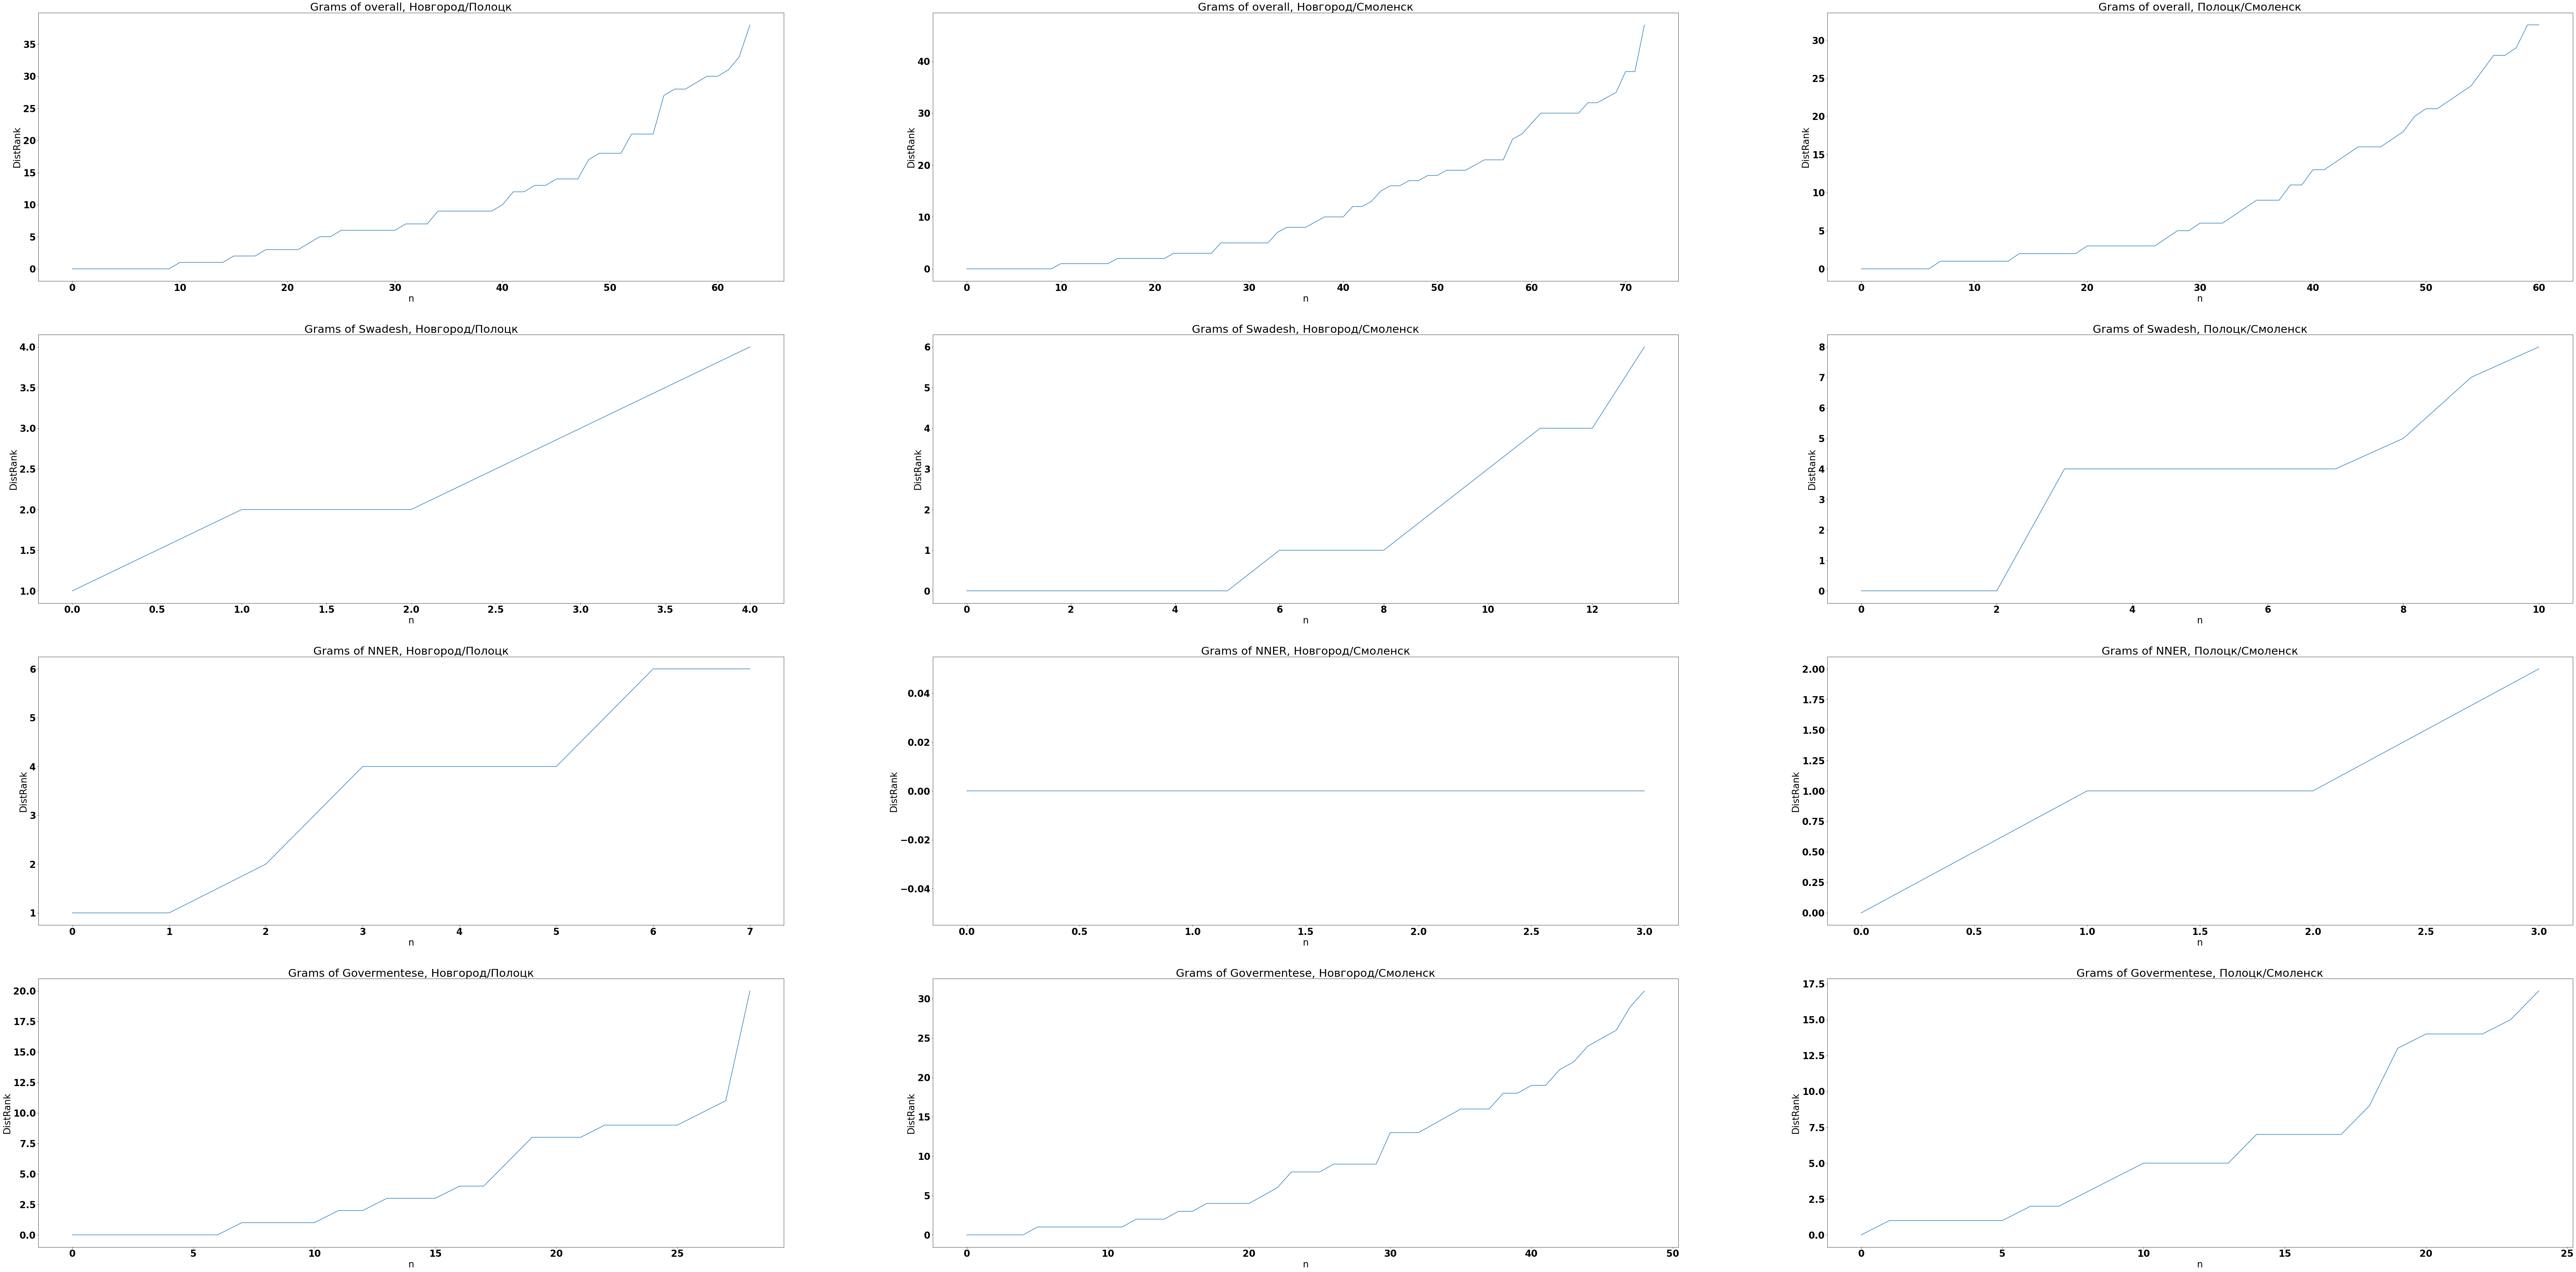

In [121]:
print_dist_rank_results(df)

## Hardy-Weinberg tests

In [54]:
def get_dataset_for_HW(raw_df):
  cleansed_df = cleanse(df)
  locations = list(df['LOCATION'].unique())
  df_by_locs = {}
  for location in locations:
    df_by_loc = df[df['LOCATION'] == location]
    texts = list(df_by_loc['DOC'].unique())
    texts_in_loc = {}
    for text in texts:
      texts_in_loc[text] = df_by_loc[df_by_loc['DOC'] == text]       
    df_by_locs[location] = texts_in_loc
  df_by_locs = n_grams_by_locations(df_by_locs)
  df_by_locs_and_n_grams = get_n_gram_lists(df_by_locs)
  return df_by_locs_and_n_grams

In [55]:
def FSTs(lists):
  fsts = {}
  for category in lists.keys():
    fsts[category] = {}
    enumerated_locations = sorted(lists[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        fsts[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = FST(lists[category][enumerated_locations[i]], lists[category][enumerated_locations[j]])
  return fsts

In [56]:
def get_HWs(df_texts):
  df_hws = {}
  for location in df_texts.keys():
    hws = []
    texts = list(enumerate(sorted(df_texts[location].keys())))
    if (len(texts) > 1):
      for i,v in texts:
        for j in range(i + 1, len(texts)):
          hws.append(FST(df_texts[location][texts[i][1]], df_texts[location][texts[j][1]]))
      hws = sum(hws)/len(hws)
      df_hws[location] = hws
  return df_hws

In [57]:
def tests_HW(lists, df):
  return {'FST': FSTs(lists), 'HW': get_HWs(get_dataset_for_HW(df))}

In [58]:
def print_FST_results(analysis):
  for location in analysis["HW"].keys():
    print(f'Average F-statistics for {location} texts: {analysis["HW"][location]}')
  for category in analysis["FST"].keys():
    for locations in analysis["FST"][category].keys():
      print(f'F-statistics in {category} n-grams for {locations} pair: {analysis["FST"][category][locations]}') 
      

In [59]:
print_FST_results(tests_HW(extract_n_grams_and_counters(df)['grams'], df))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


F-statistics in overall n-grams for Австралия/Германия pair: 0.8058694413247739
F-statistics in overall n-grams for Австралия/Намибия pair: 0.7953902340990782
F-statistics in overall n-grams for Германия/Намибия pair: 0.803114365345429


## Levenshtein distance tests

In [60]:
def get_levs(counters, count):
  levs = {}
  for category in counters.keys():
    levs[category] = {}
    enumerated_locations = sorted(counters[category].keys())
    for i,v in enumerate(enumerated_locations):
      for j in range(i + 1, len(enumerated_locations)):
        levs[category][enumerated_locations[i] + '/' + enumerated_locations[j]] = []
        for c in range(count):
          levs[category][enumerated_locations[i] + '/' + enumerated_locations[j]].append(dameraulevenshtein(counters[category][enumerated_locations[i]][c][0], counters[category][enumerated_locations[j]][c][0]))
  return levs        

In [61]:
def normal_levs(levs):
  normals = {}
  for category in levs.keys():    
    normals[category] = {}
    enumerated_locations = sorted(levs[category].keys())
    for i,v in enumerate(enumerated_locations):
      try:
        result = normaltest(sorted(levs[category][enumerated_locations[i]])).pvalue
        normals[category][enumerated_locations[i]] = "Normal distribution" if result >= 0.05 else "Not normal distribution"
      except:
        normals[category][enumerated_locations[i]] = "No sufficient data"
  return normals

In [62]:
def variance_analysis_levs(levs):
  manyways = {}
  for category in levs.keys():    
    ranks = []
    results = []
    enumerated_locations = sorted(levs[category].keys())
    for i,v in enumerate(enumerated_locations):     
      try:
        result = normaltest(sorted(levs[category][enumerated_locations[i]])).pvalue
        result = "Normal distribution" if result >= 0.05 else "Not normal distribution"          
      except:
        result = "No sufficient data"
      ranks.append(sorted(levs[category][enumerated_locations[i]]))
      results.append(results)
    if (("No sufficient data" in results) or ("Not normal distribution" in results)):
      manyways[category] = kruskal(*ranks).pvalue
      continue
    manyways[category] = f_oneway(*ranks).pvalue    
  return manyways

In [63]:
def get_averaged_levs(levs):
  averaged_levs = {}
  for category in levs.keys():
    averaged_levs[category] = {}
    enumerated_locations = sorted(levs[category].keys())
    for i,v in enumerate(enumerated_locations):
      averaged_levs[category][enumerated_locations[i]] = math.log(sum(levs[category][enumerated_locations[i]])/len(levs[category][enumerated_locations[i]]) + 1)/math.log(max(levs[category][enumerated_locations[i]]) + 1)
  return averaged_levs

In [64]:
def previous_shift_levs(levs):
  previous_levs = {}
  for category in levs.keys():
    previous_levs[category] = {}
    enumerated_locations = sorted(levs[category].keys())
    for i,v in enumerate(enumerated_locations):
      previous_levs[category][enumerated_locations[i]] = previous_change(levs[category][enumerated_locations[i]])
  return previous_levs

In [65]:
def plot_levs(levs):
  %matplotlib inline
  font = {'family':'DejaVu Sans', 'weight':'bold', 'size':26}
  matplotlib.rc('font', **font)
  graph_counter = 1
  plt.figure(figsize=(128, 64))
  for category in levs.keys():
    enumerated_locations = sorted(levs[category].keys())
    for i,v in enumerate(enumerated_locations):
      plt.subplot(4,3, graph_counter, xlabel="Rank", ylabel="Damerau-Levenshtein distance", title="Grams of " + category + ", " + enumerated_locations[i])
      x = range(len(levs[category][enumerated_locations[i]]))
      y = sorted(levs[category][enumerated_locations[i]])
      sns.lineplot(x=x, y=y)
      graph_counter = graph_counter + 1
  plt.savefig('plots_levs_n_grams.png')

In [66]:
def test_levs(levs):
  return {'Normality' : normal_levs(levs), 'Variance': variance_analysis_levs(levs), 'Averaged': get_averaged_levs(levs), 
          'Previous shift': previous_shift_levs(levs)}

In [67]:
def print_levs_test(counters, count = 50):
  levs = get_levs(counters, count)
  analysis = test_levs(levs)
  for category in analysis["Normality"].keys():
    for locations in analysis["Normality"][category].keys():
      print(f'Normality test of Levenshtein distance in {category} for {count} most-frequent n-grams for {locations} pair: {analysis["Normality"][category][locations]}')
  for category in analysis["Variance"].keys():
    print(f'Analysis of variance test of Levenshtein distance in {category} for {count} most-frequent n-grams results: {analysis["Variance"][category]}')
  for category in analysis["Averaged"].keys():
    for locations in analysis["Normality"][category].keys():
      print(f'Average Levenshtein distance in {category} for {count} most-frequent n-grams for {locations} pair results: {analysis["Averaged"][category][locations]}')
  for category in analysis["Previous shift"].keys():
    for locations in analysis["Normality"][category].keys():
      print(f'Previous shift by Levenshtein distance in {category} for {count} most-frequent n-grams for {locations} pair results: {analysis["Previous shift"][category][locations]}')
  plot_levs(levs)


Normality test of Levenshtein distance in overall for 50 most-frequent n-grams for Австралия/Германия pair: Not normal distribution
Normality test of Levenshtein distance in overall for 50 most-frequent n-grams for Австралия/Намибия pair: Not normal distribution
Normality test of Levenshtein distance in overall for 50 most-frequent n-grams for Германия/Намибия pair: Not normal distribution
Analysis of variance test of Levenshtein distance in overall for 50 most-frequent n-grams results: 0.2567825569324464
Average Levenshtein distance in overall for 50 most-frequent n-grams for Австралия/Германия pair results: 0.9319692252119859
Average Levenshtein distance in overall for 50 most-frequent n-grams for Австралия/Намибия pair results: 0.9159386205958365
Average Levenshtein distance in overall for 50 most-frequent n-grams for Германия/Намибия pair results: 0.9591931172231739
Previous shift by Levenshtein distance in overall for 50 most-frequent n-grams for Австралия/Германия pair results: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


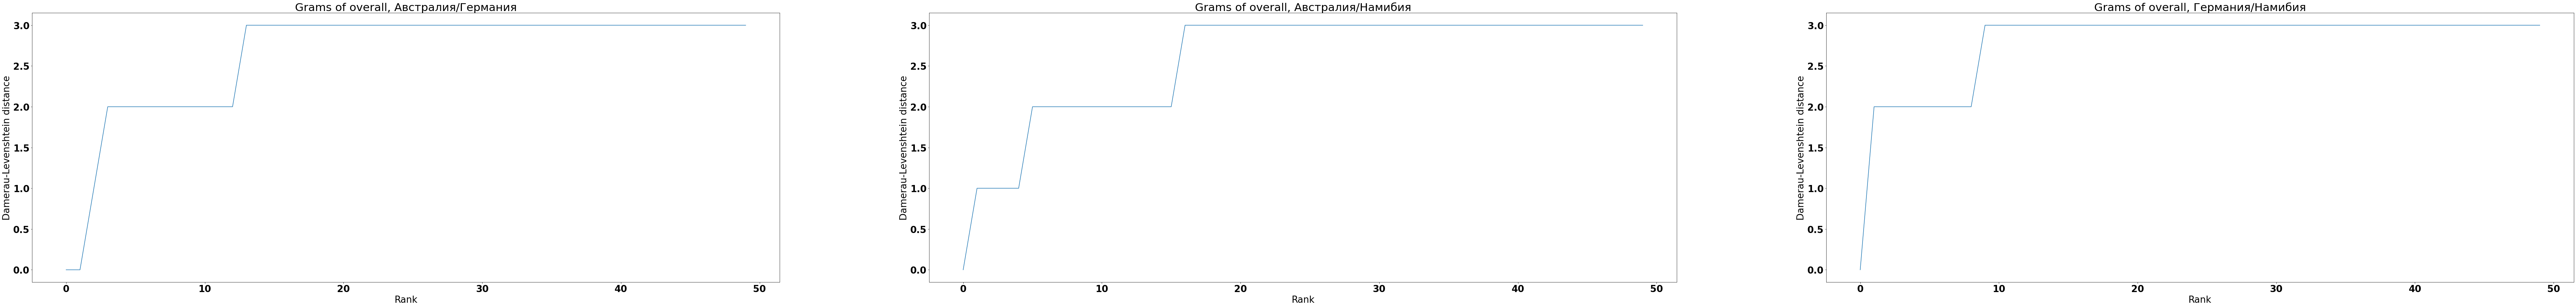

In [68]:
print_levs_test(extract_n_grams_and_counters(df)['counters'])

# Topic modelling

## Preprocess

In [230]:
def split_into_texts(df_non_split):
  texts = list(df_non_split['DOC'].unique())
  df_by_texts = {}
  for text in texts:
    df_by_texts[text] = df_non_split[df_non_split['DOC'] == text]
  return df_by_texts

In [231]:
def get_vocabs(texts_df):
  vocabs = []
  for doc in texts_df.keys():
    vocabs.append(list(texts_df[doc]['TOKEN']))
  return vocabs

In [232]:
def delete_stop_words(texts_df, vocabs):
  cleaned_df = texts_df
  vocab = [word for doc in vocabs for word in doc]
  stop_words = get_stop_words(vocab, vocabs, 0.02)
  for stop_word in stop_words:
    for text in cleaned_df.keys():
      cleaned_df[text] = cleaned_df[text][cleaned_df[text]['TOKEN'] != stop_word]
  return cleaned_df

In [233]:
def n_grams_by_texts(df_by_texts, n = 3):
  df_by_n_grams = {}
  for text in df_by_texts.keys():
    df_text = df_by_texts[text]
    df_text['N-GRAMS'] = df_text['TOKEN'].apply(lambda x: n_grams(x, n))
    df_by_n_grams[text] = df_text      
  return df_by_n_grams

In [234]:
def joined_n_grams_by_texts(df_n):
  dict_n_gram_cols = []
  for text in df_n.keys():
    n_gram_cols = []
    for index, row in df_n[text].iterrows():
      n_gram_cols.append(' '.join(row['N-GRAMS']))
    n_gram_cols = ' '.join(n_gram_cols)
    dict_n_gram_cols.append(n_gram_cols)
  return dict_n_gram_cols

In [235]:
def joined_token(df_n):
  dict_texts = []
  for text in df_n.keys():
    text_cols = []
    for index, row in df_n[text].iterrows():
      text_cols.append(row['TOKEN'])
    dict_texts.append(text_cols)
  return dict_texts

In [236]:
def preprocess_dirichlet(df_dirichlet):
  cleansed_df = cleanse(df_dirichlet)
  df_by_texts = split_into_texts(cleansed_df)
  vocabularies_acquired = get_vocabs(df_by_texts)
  cleaned = delete_stop_words(df_by_texts, vocabularies_acquired)
  df_n_grams = n_grams_by_texts(cleaned)
  keys = list(df_n_grams.keys())
  df_cols = joined_n_grams_by_texts(df_n_grams)
  vectorized_cols = vectorize_cols(df_cols)
  joined_texts = joined_token(df_n_grams)
  return {'keys': keys, 'vectors': vectorized_cols, 'texts': joined_texts}

### Analysis

In [237]:
def dirichlet_test(df_dirichlet):
  preprocessed_df = preprocess_dirichlet(df_dirichlet)
  cosine_similarities = cosine_similarity(preprocessed_df['vectors'], preprocessed_df['vectors'])
  dirichlets = dirichlet(preprocessed_df['texts'])
  return {'Keys': preprocessed_df['keys'],'Cos': cosine_similarities, 'Dirichlets': dirichlets}


In [238]:
def plot_cosines(names, cosines):
  lists_result = []
  for row in cosines:
    lists_result.append([number for number in row if number != 0])
  distance_matrix = _DistanceMatrix(names, lists_result)
  constructor = DistanceTreeConstructor()
  tree = constructor.upgma(distance_matrix)
  %matplotlib inline
  font = {'family':'DejaVu Sans', 'weight':'normal', 'size':14}
  matplotlib.rc('font', **font)
  fig = plt.figure(figsize=(40, 10))
  fig.suptitle('Lects tree by cosine similarities', fontsize=20)
  axes = fig.add_subplot(1, 1, 1)
  Phylo.draw(tree, axes=axes, show_confidence=False, do_show=False)  
  plt.savefig('phylogeny.png')
  plt.show()

In [239]:
def print_dirichlet_test(df_dirichlet):  
  try:
    analysis = dirichlet_test(df_dirichlet)
    print('LDA:')    
    for i,topic in analysis['Dirichlets'].show_topics(formatted=True, num_topics=10, num_words=10):
        print(str(i)+": "+ topic)
        print()
    plot_cosines(analysis['Keys'], np.tril(analysis['Cos']).tolist())
  except ValueError:
    print("No sufficient information")
  

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
LDA:
0: 0.064*"ризѣ" + 0.045*"дати" + 0.044*"ли" + 0.039*"имъ" + 0.036*"~г~" + 0.033*"его" + 0.029*"како" + 0.028*"платити" + 0.025*"ѹбьють" + 0.023*"соромъ"

1: 0.089*"ризѣ" + 0.050*"его" + 0.046*"дати" + 0.032*"како" + 0.028*"при" + 0.028*"~г~" + 0.028*"ли" + 0.028*"имъ" + 0.023*"ѹбьють" + 0.023*"платити"

2: 0.098*"ѡже" + 0.036*"бес" + 0.030*"есмь" + 0.029*"пакости" + 0.024*"до" + 0.024*"се" + 0.024*"посломь" + 0.022*"тѧжа" + 0.018*"ваша" + 0.018*"нѣмци"

3: 0.094*"што" + 0.079*"землѧ" + 0.058*"ѡже" + 0.041*"того" + 0.041*"ту" + 0.038*"искати" + 0.035*"лѣтъ" + 0.035*"кнѧзѧ" + 0.034*"будеть" + 0.034*"богъ"

4: 0.048*"ѡже" + 0.041*"ризѣ" + 0.032*"тѧжа" + 0.026*"головѹ" + 0.025*"ѹбьють" + 0.025*"ли" + 0.024*"имъ" + 0.023*"~г~" + 0.017*"дати" + 0.017*"соромъ"



/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


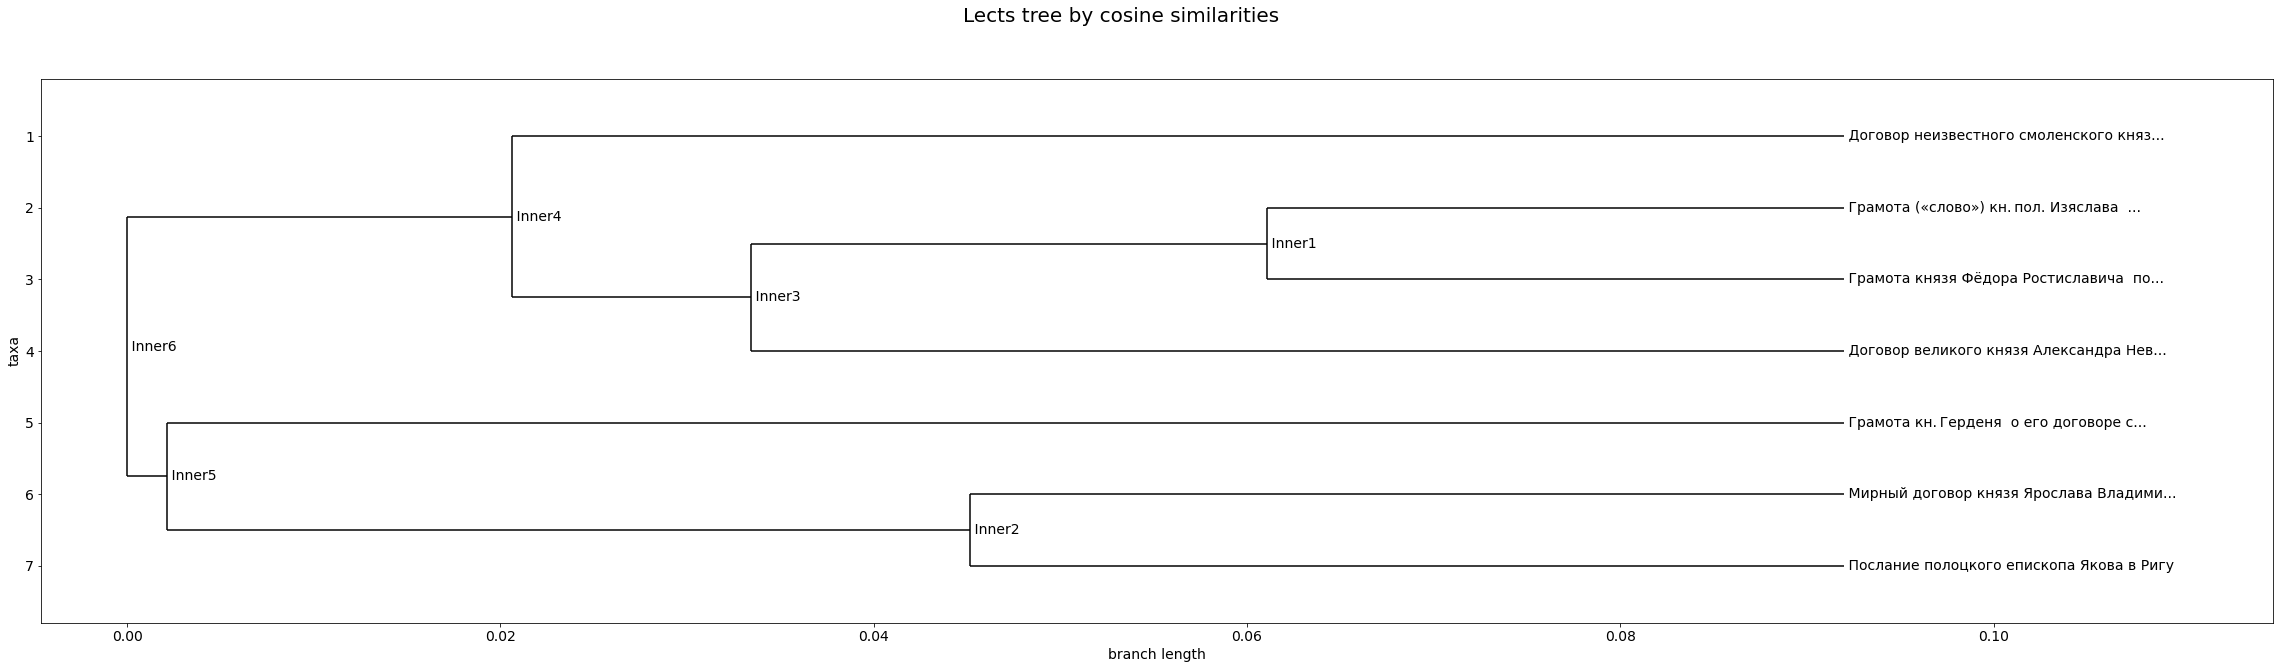

In [240]:
print_dirichlet_test(df)